# What is Pneumonia?
Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases. Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community or hospital-acquired or healthcare-associated pneumonia.

# Setup

In [1]:
import os
import sys

if not os.path.exists("../data"):
    # import data from zip file
    import zipfile as zf
    files = zf.ZipFile("data.zip", 'r')
    files.extractall(".")
    files.close()

# Importing the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import keras
import keras.backend as K
from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, TensorBoard
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from mlxtend.plotting import plot_confusion_matrix
import cv2
import shutil
import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis

import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.15.0
2.2.4


In [3]:
from tensorflow.python.client import device_lib

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

print("GPU in use:", tf.test.is_gpu_available())
device_lib.list_local_devices()

GPU in use: True


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3727860475559791141,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6146707350557184016
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1494142623926032365
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10990990132
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 14827162211713834207
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:8a:00.0, compute capability: 6.1"]

# Description of the Pneumonia Dataset
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [ ]:
# Split Pneumonia images into bacteria and viral infection instaces
for dataset in os.listdir("../data"):
    if not os.path.exists(os.path.join("../data", dataset, "BACTERIA")):
        os.mkdir(os.path.join("../data", dataset, "BACTERIA"))
    if not os.path.exists(os.path.join("../data", dataset, "VIRUS")):
        os.mkdir(os.path.join("../data", dataset, "VIRUS"))
    for pneumonia in tqdm(os.listdir(os.path.join("../data", dataset, "PNEUMONIA"))):
        if "virus" in pneumonia:
            shutil.copyfile(os.path.join("../data", dataset, "PNEUMONIA", pneumonia), os.path.join("../data", dataset, "VIRUS", pneumonia))
        elif "bacteria" in pneumonia:
            shutil.copyfile(os.path.join("../data", dataset, "PNEUMONIA", pneumonia), os.path.join("../data", dataset, "BACTERIA", pneumonia))

In [ ]:
# Create 80/20 training/validation sets from data
for i in random.sample(os.listdir("../data/train/VIRUS"), 269):
    shutil.move(os.path.join("../data/train/VIRUS", i), os.path.join("../data/val/VIRUS", i))
    
for i in random.sample(os.listdir("../data/train/BACTERIA"), 507):
    shutil.move(os.path.join("../data/train/BACTERIA", i), os.path.join("../data/val/BACTERIA", i))
    
for i in random.sample(os.listdir("../data/train/NORMAL"), 270):
    shutil.move(os.path.join("../data/train/NORMAL", i), os.path.join("../data/val/NORMAL", i))

In [4]:
# Class Balancing
if not os.path.exists(os.path.join("../data/train", "BACTERIA_SUB")):
        os.mkdir(os.path.join("../data/train", "BACTERIA_SUB"))
        
if not os.path.exists(os.path.join("../data/val", "BACTERIA_SUB")):
        os.mkdir(os.path.join("../data/val", "BACTERIA_SUB"))

for i in random.sample(os.listdir("../data/train/BACTERIA"), 1075):
    shutil.copyfile(os.path.join("../data/train/BACTERIA", i), os.path.join("../data/train/BACTERIA_SUB", i))
    
for i in random.sample(os.listdir("../data/val/BACTERIA"), 270):
    shutil.copyfile(os.path.join("../data/val/BACTERIA", i), os.path.join("../data/val/BACTERIA_SUB", i))

In [ ]:
# Move more to Normal class (training)
for i in random.sample(os.listdir("../data/test/NORMAL"), 100):
    shutil.move(os.path.join("../data/test/NORMAL", i), os.path.join("../data/train/NORMAL", i))
    
for i in random.sample(os.listdir("../data/train/VIRUS"), 100):
    shutil.move(os.path.join("../data/train/VIRUS", i), os.path.join("../data/test/VIRUS", i))

In [7]:
print("Training virus instances:", len(os.listdir("../data/train/VIRUS")))
print("Training bacteria instances:", len(os.listdir("../data/train/BACTERIA_SUB")))
print("Training normal instances:", len(os.listdir("../data/train/NORMAL")))
print("Validation virus instances:", len(os.listdir("../data/val/VIRUS")))
print("Validation bacteria instances:", len(os.listdir("../data/val/BACTERIA_SUB")))
print("Validation normal instances:", len(os.listdir("../data/val/NORMAL")))
print("Test virus instances:", len(os.listdir("../data/test/VIRUS")))
print("Test bacteria instances:", len(os.listdir("../data/test/BACTERIA")))
print("Test normal instances:", len(os.listdir("../data/test/NORMAL")))

Training virus instances: 976
Training bacteria instances: 1075
Training normal instances: 1171
Validation virus instances: 269
Validation bacteria instances: 270
Validation normal instances: 278
Test virus instances: 248
Test bacteria instances: 242
Test normal instances: 134


In [8]:
labels = ['BACTERIA', 'VIRUS', 'NORMAL']
#labels = ["PNEUMONIA", "NORMAL"]
IMG_SIZE = 150

def load_data(data_dir):
    data = [] 
    for label in labels:
        # Class Balancing
        if label == "BACTERIA" and (data_dir=="../data/train" or data_dir=="../data/val"):
            label = "BACTERIA_SUB"

        path = os.path.join(data_dir, label)
        class_num = labels.index(label) if label != "BACTERIA_SUB" else 0
        for img in os.listdir(path):
            try:
                #img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [9]:
train = load_data('../data/train')
test = load_data('../data/test')
val = load_data('../data/val')

# Data Visualization & Preprocessing

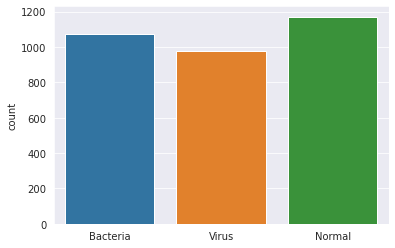

In [10]:
l = []
for i in train:
    if (i[1] == 0):
        l.append("Bacteria")
    elif (i[1] == 1):
        l.append("Virus")
    else:
        l.append("Normal")

sns.set_style('darkgrid')
sns.countplot(l)

Previewing the images of both the classes

Text(0.5, 1.0, 'NORMAL')

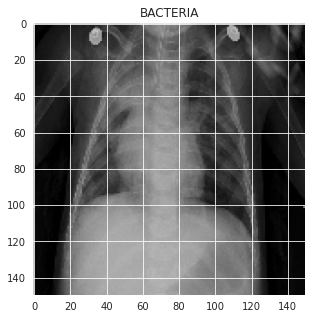

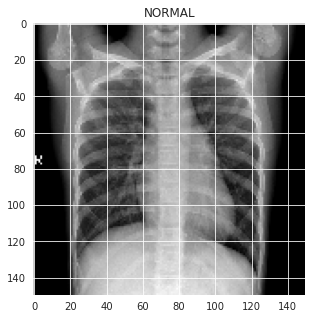

In [11]:
plt.figure(figsize=(5, 5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize=(5, 5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [12]:
x_train = []
y_train = []
#x_train = np.array([], dtype="float")
#y_train = np.array([], dtype="float")

x_val = []
y_val = []
#x_val = np.array([], dtype="float")
#y_val = np.array([], dtype="float")

x_test = []
y_test = []
#x_test = np.array([], dtype="float")
#x_test = np.array([], dtype="float")

for feature, label in tqdm(train):
    x_train.append(feature)
    y_train.append(label)
    #x_train = np.append(x_train, feature)
    #y_train = np.append(y_train, label)

for feature, label in tqdm(test):
    x_test.append(feature)
    y_test.append(label)
    #x_test = np.append(x_test, feature)
    #y_test = np.append(y_test, label)
    
for feature, label in tqdm(val):
    x_val.append(feature)
    y_val.append(label)
    #x_val = np.append(x_val, feature)
    #y_val = np.append(x_val, label)

100%|██████████| 817/817 [00:00<00:00, 511302.05it/s]


Perform normalization to reduce the effect of illumination's differences. Moreover the CNN converges faster on range [0, 1] data than on range [0, 255]

In [13]:
x_train = np.array(x_train, dtype="float")
x_val = np.array(x_val, dtype="float")
x_test = np.array(x_test, dtype="float")

In [14]:
# resize data for deep learning 
x_train = x_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_test = np.array(y_test)

In [15]:
def create_preprocessing_f(X, input_range=[0, 1]):
    """
    Generically shifts data from interval [a, b] to interval [c, d].
    Assumes that theoretical min and max values are populated.
    """
    if len(input_range) != 2:
        raise ValueError(
            "Input range must be of length 2, but was {}".format(
                len(input_range)))
    if input_range[0] >= input_range[1]:
        raise ValueError(
            "Values in input_range must be ascending. It is {}".format(
                input_range))

    a, b = X.min(), X.max()
    c, d = input_range

    def preprocessing(X):
        # shift original data to [0, b-a] (and copy)
        X = X - a
        # scale to new range gap [0, d-c]
        X /= (b-a)
        X *= (d-c)
        # shift to desired output range
        X += c
        return X

    def revert_preprocessing(X):
        X = X - c
        X /= (d-c)
        X *= (b-a)
        X += a
        return X

    return preprocessing, revert_preprocessing

In [16]:
input_range = [0, 1]
preprocess, revert_preprocessing = create_preprocessing_f(x_train, input_range)

data = (
    preprocess(x_train), y_train,
    preprocess(x_val), y_val
)

In [17]:
num_classes = len(np.unique(data[1]))
label_to_class_name = labels

# Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(data[0])

Data Augmentation:
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Training the Model

### VGG16

In [19]:
# Check tensorflow/keras usage for model/layers 
K.clear_session()

base_model = VGG16(weights='../models/weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(num_classes, activation='softmax', name="concept")(x)

model = Model(inputs=base_model.input, outputs=x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### ResNet50

In [ ]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='./models/weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'))
model.add(Dense(num_classes, activation='softmax'))

model.layers[0].trainable = False
model.summary()

## Training

In [20]:
def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    return K.categorical_crossentropy(y_pred, y_true) * final_mask


w_array = np.ones((2, 2))
w_array[1, 0] = 30 # penalizing false negative
w_array[0, 1] = 1 # penalizing false positive

spec_loss = lambda y_true, y_pred: w_categorical_crossentropy(y_true, y_pred, weights=w_array)

y_labels = np.argmax(keras.utils.to_categorical(data[1], num_classes), axis=1)
classweight = class_weight.compute_class_weight("balanced", np.unique(y_labels), y_labels)
print(classweight)

[0.99906977 1.10040984 0.91716482]


In [21]:
%load_ext tensorboard
learning_rate_reduction = ReduceLROnPlateau(monitor="val_acc", 
                                            factor=0.3, 
                                            #epsilon=0.0001, 
                                            patience=3, 
                                            verbose=1, 
                                            min_lr=0.000001)

tensorboard_callback = TensorBoard(log_dir="logs", 
                                   histogram_freq=1, 
                                   write_graph=False, 
                                   update_freq="epoch")

In [22]:
# freeze pretrained layers during initial training
for layer in model.layers[0:19]:
    layer.trainable = False
    
for i, layer in enumerate(model.layers):
        print("Layer {}: {}, Trainable: {}".format(i, layer.name, layer.trainable))

Layer 0: input_1, Trainable: False
Layer 1: block1_conv1, Trainable: False
Layer 2: block1_conv2, Trainable: False
Layer 3: block1_pool, Trainable: False
Layer 4: block2_conv1, Trainable: False
Layer 5: block2_conv2, Trainable: False
Layer 6: block2_pool, Trainable: False
Layer 7: block3_conv1, Trainable: False
Layer 8: block3_conv2, Trainable: False
Layer 9: block3_conv3, Trainable: False
Layer 10: block3_pool, Trainable: False
Layer 11: block4_conv1, Trainable: False
Layer 12: block4_conv2, Trainable: False
Layer 13: block4_conv3, Trainable: False
Layer 14: block4_pool, Trainable: False
Layer 15: block5_conv1, Trainable: False
Layer 16: block5_conv2, Trainable: False
Layer 17: block5_conv3, Trainable: False
Layer 18: block5_pool, Trainable: False
Layer 19: flatten_1, Trainable: True
Layer 20: concept, Trainable: True


In [23]:
ohe_y_train = keras.utils.to_categorical(data[1], num_classes)
ohe_y_val = keras.utils.to_categorical(data[3], num_classes)


EPOCHS = 20
BATCH_SIZE = 64

optimizer = Adam(lr=0.0001)

model.compile(loss="categorical_crossentropy",     #  loss=spec_loss,
              optimizer=optimizer, 
              metrics=["accuracy"])

history = model.fit(x=data[0], y=ohe_y_train,
                    class_weight=classweight,
                    validation_data=(data[2], ohe_y_val),
                    shuffle=True,
                    callbacks=[learning_rate_reduction],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3222 samples, validate on 817 samples
Epoch 1/20
3222/3222 [==============================] - 12s 4ms/step - loss: 0.9791 - acc: 0.5497 - val_loss: 0.8376 - val_acc: 0.6793
Epoch 2/20
3222/3222 [==============================] - 8s 2ms/step - loss: 0.7483 - acc: 0.7250 - val_loss: 0.7103 - val_acc: 0.7234
Epoch 3/20
3222/3222 [==============================] - 9s 3ms/step - loss: 0.6534 - acc: 0.7604 - val_loss: 0.6418 - val_acc: 0.7417
Epoch 4/20
3222/3222 [==============================] - 9s 3ms/step - loss: 0.6019 - acc: 0.7709 - val_loss: 0.6076 - val_acc: 0.7491
Epoch 5/20
3222/3222 [==============================] - 8s 3ms/step - loss: 0.5660 - acc: 0.7812 - val_loss: 0.5785 - val_acc: 0.7564
Epoch 6/20
3222/3222 [==============================] - 8s 2ms/step - loss: 0.5434 - acc: 0.7849 - val_loss: 0.5689 - val_acc: 0.7601
Epoch 7/20
3222/3222 [============================

In [ ]:
# unfreeze pretrained layers during second round of training
for layer in model.layers[0:18]:
    layer.trainable = True
    
for i, layer in enumerate(model.layers):
        print("Layer {}: {}, Trainable: {}".format(i, layer.name, layer.trainable))

In [ ]:
optimizer = Adam(lr=0.00001)

model.compile(loss="categorical_crossentropy",     #  loss=spec_loss,
              optimizer=optimizer, 
              metrics=["accuracy"])


history_2 = model.fit(x=data[0], y=ohe_y_train,
                    class_weight=classweight,
                    validation_data=(data[2], ohe_y_val),
                    shuffle=True,
                    callbacks=[learning_rate_reduction],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1)

In [ ]:
# FOR TESTING/DEBUGGING #
'''
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 1)),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(num_classes, activation="softmax")
])

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),
    keras.layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),
    keras.layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),
    keras.layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),
    keras.layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=num_classes, activation='softmax') 
])


#sparse_categorical_corssentropy for non one-hot encoded output
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())


EPOCHS = 50
BATCH_SIZE = 32

ohe_y_train = keras.utils.to_categorical(data[1], num_classes)
ohe_y_val = keras.utils.to_categorical(data[3], num_classes)

history = model.fit(data[0], ohe_y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data = (data[2], ohe_y_val),
                    callbacks=[learning_rate_reduction],
                    verbose=1)
                    

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    history = model.fit_generator(datagen.flow(data[0], ohe_y_train, batch_size = BATCH_SIZE),
                                  epochs = EPOCHS, 
                                  steps_per_epoch = data[0].shape[0]//BATCH_SIZE,
                                  validation_data = datagen.flow(data[2], ohe_y_val),
                                  validation_steps = data[2].shape[0]//BATCH_SIZE,
                                  #callbacks = [learning_rate_reduction],
                                  verbose=1)
'''

Evaluate model on test data

In [24]:
input_range = [0, 1]
preprocess, revert_preprocessing = create_preprocessing_f(x_test, input_range)
x_test = preprocess(x_test)
ohe_y_test = keras.utils.to_categorical(y_test, num_classes)

print("Testing Loss:" , model.evaluate(x_test, ohe_y_test)[0])
print("Testing Accuracy:" , model.evaluate(x_test, ohe_y_test)[1]*100 , "%")

624/624 [==============================] - 2s 3ms/step
Testing Loss: 0.5562517612408369
624/624 [==============================] - 1s 2ms/step
Testing Accuracy: 81.41025641025641 %


# Model Performance Analysis

Training and Validation Loss/Accuracy per epoch

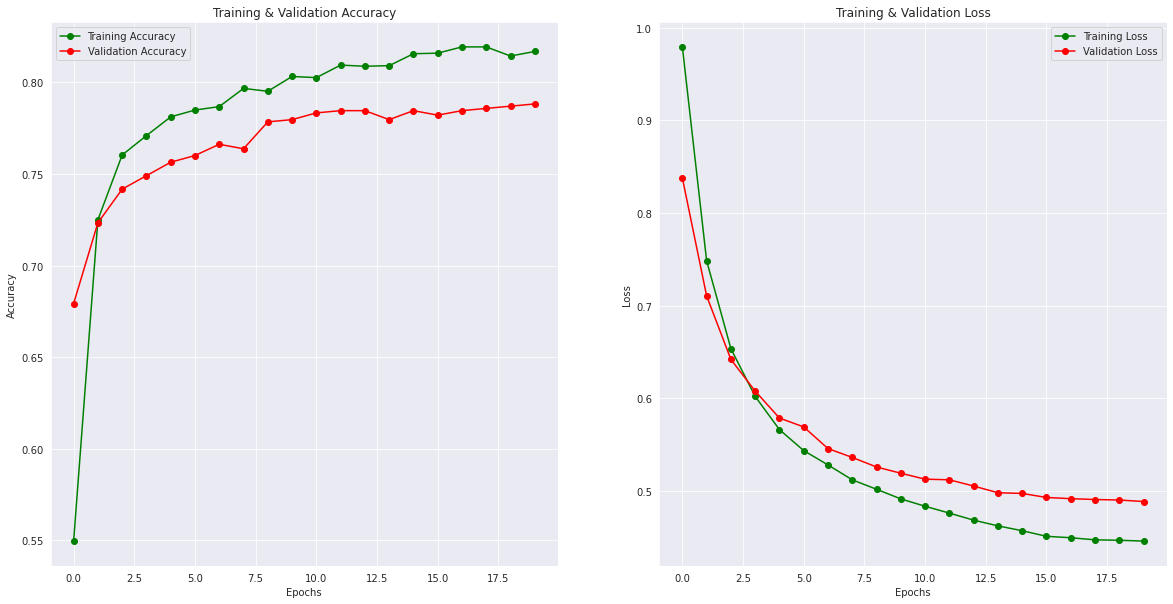

In [25]:
epochs = [i for i in range(EPOCHS)]

fig , ax = plt.subplots(1, 2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs, val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [26]:
#predictions = model.predict_classes(x_test)
predictions = model.predict(x_test).argmax(axis=-1)
predictions = predictions.reshape(1, -1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [27]:
print(classification_report(y_test, predictions, target_names = labels))

              precision    recall  f1-score   support

    BACTERIA       0.78      0.92      0.85       242
       VIRUS       0.83      0.75      0.79       248
      NORMAL       0.85      0.75      0.79       134

    accuracy                           0.81       624
   macro avg       0.82      0.80      0.81       624
weighted avg       0.82      0.81      0.81       624



In [28]:
cm = confusion_matrix(y_test, predictions)
cm

array([[222,  12,   8],
       [ 52, 186,  10],
       [  9,  25, 100]])

In [29]:
cm = pd.DataFrame(cm , index = ['0', '1', '2'] , columns = ['0', '1', '2'])

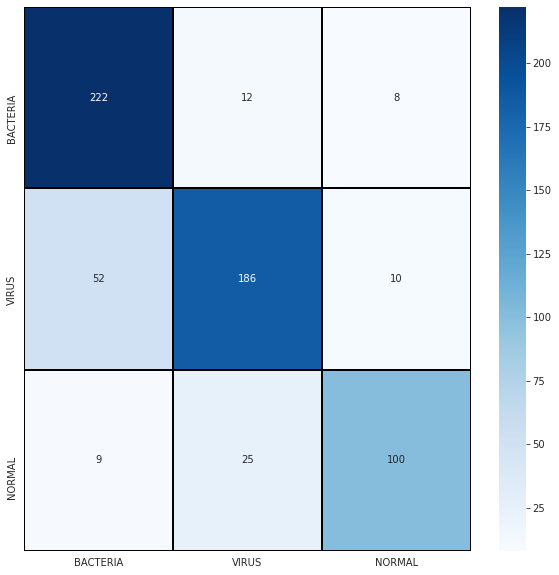

In [30]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

Correct: 508
Incorrect: 116


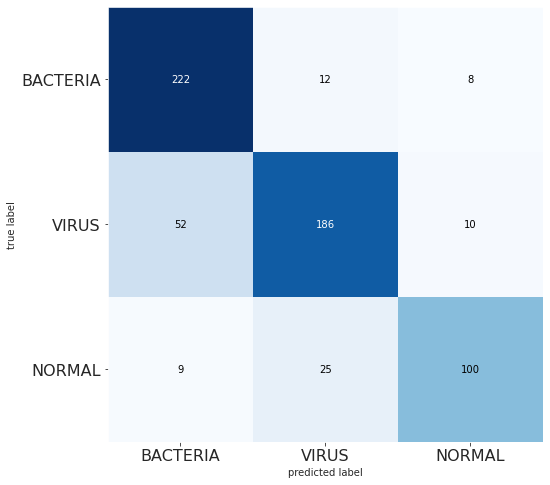

In [31]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]
print("Correct:", len(correct))
print("Incorrect:", len(incorrect))

y_pred = model.predict(x_test)
# to get the prediction, we pick the class with with the highest probability
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(keras.utils.to_categorical(y_test, num_classes), axis = 1) 


conf_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(conf_mtx, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(3), labels, fontsize=16)
plt.yticks(range(3), labels, fontsize=16)
plt.show()

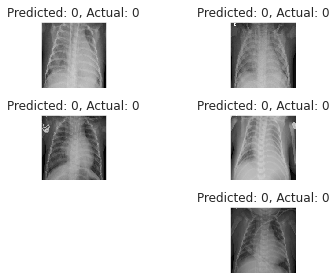

In [32]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150, 150, 3), cmap="gray", interpolation='none')
    plt.title("Predicted: {}, Actual: {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

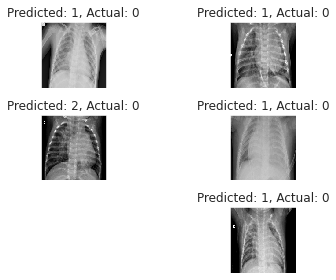

In [33]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150, 150, 3), cmap="gray", interpolation='none')
    plt.title("Predicted: {}, Actual: {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

# Layer-wise Relevance Propagation

In [34]:
def postprocess(X):
    X = X.copy()
    X = iutils.postprocess_images(X)
    return X


def bk_proj(X):
    return ivis.graymap(X)


def heatmap(X):
    return ivis.heatmap(X)


def graymap(X):
    return ivis.graymap(np.abs(X))

In [35]:
# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    #return revert_preprocessing(X)
    return revert_preprocessing(X) / 255

noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input

# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",                 {},                       input_postprocessing,      "Input"),

    # Signal
    ("deconvnet",             {},                       bk_proj,        "Deconvnet"),
    ("lrp.z",                 {},                       heatmap,        "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           heatmap,        "LRP-Epsilon"),
]

In [36]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters

    # Some analyzers require training.
    analyzer.fit(data[0], batch_size=BATCH_SIZE, verbose=1)
    analyzers.append(analyzer)

In [37]:
n = 10
test_images = list(zip(data[0][:n], data[1][:n]))

analysis = np.zeros([len(test_images), len(analyzers), IMG_SIZE, IMG_SIZE, 3])
text = []


for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
    
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        # Analyze.
        a = analyzer.analyze(x)
        
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        a = postprocess(a)
        # Apply analysis postprocessing, e.g., creating a heatmap.
        a = methods[aidx][2](a)
        # Store the analysis.
        analysis[i, aidx] = a[0]

In [38]:
def plot_image_grid(grid,
                    row_labels_left,
                    row_labels_right,
                    col_labels,
                    file_name=None,
                    figsize=None,
                    dpi=224):
    n_rows = len(grid)
    n_cols = len(grid[0])
    if figsize is None:
        figsize = (n_cols, n_rows+1)

    plt.clf()
    plt.rc("font", family="sans-serif")

    plt.figure(figsize=figsize)
    for r in range(n_rows):
        for c in range(n_cols):
            ax = plt.subplot2grid(shape=[n_rows+1, n_cols], loc=[r+1, c])
            # TODO controlled color mapping wrt all grid entries,
            # or individually. make input param
            if grid[r][c] is not None:
                ax.imshow(grid[r][c], interpolation='none')
            else:
                for spine in plt.gca().spines.values():
                    spine.set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

            # column labels
            if not r:
                if col_labels != []:
                    ax.set_title(col_labels[c],
                                 rotation=22.5,
                                 horizontalalignment='left',
                                 verticalalignment='bottom')

            # row labels
            if not c:
                if row_labels_left != []:
                    txt_left = [l+'\n' for l in row_labels_left[r]]
                    ax.set_ylabel(
                        ''.join(txt_left),
                        rotation=0,
                        verticalalignment='center',
                        horizontalalignment='right',
                    )

            if c == n_cols-1:
                if row_labels_right != []:
                    txt_right = [l+'\n' for l in row_labels_right[r]]
                    ax2 = ax.twinx()
                    ax2.set_xticks([])
                    ax2.set_yticks([])
                    ax2.set_ylabel(
                        ''.join(txt_right),
                        rotation=0,
                        verticalalignment='center',
                        horizontalalignment='left'
                    )

    if file_name is None:
        plt.show()
    else:
        print('Saving figure to {}'.format(file_name))
        plt.savefig(file_name, orientation='landscape', dpi=dpi)

Saving figure to ./outputs/grid.png


FileNotFoundError: [Errno 2] No such file or directory: './outputs/grid.png'

<Figure size 432x288 with 0 Axes>

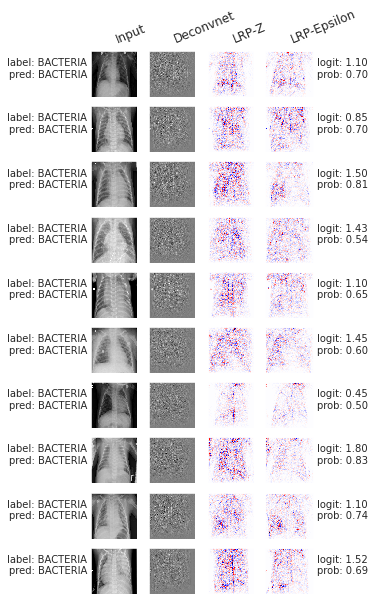

In [40]:
EXPLAIN_PATH = os.path.join("./outputs/grid.png")

grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]), 'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=EXPLAIN_PATH)

In [61]:
img = [data[0][0], data[1][0]]

analysis = np.zeros([1, len(analyzers), IMG_SIZE, IMG_SIZE, 3])
text = []


#for i, (x, y) in enumerate(test_images):
    # Add batch axis.
img[0] = img[0][None, :, :, :]

# Predict final activations, probabilites, and label.
presm = model_wo_softmax.predict_on_batch(img[0])[0]
prob = model.predict_on_batch(img[0])[0]
y_hat = prob.argmax()

# Save prediction info:
text.append(("%s" % label_to_class_name[img[1]],    # ground truth label
             "%.2f" % presm.max(),             # pre-softmax logits
             "%.2f" % prob.max(),              # probabilistic softmax output  
             "%s" % label_to_class_name[y_hat] # predicted label
            ))

for aidx, analyzer in enumerate(analyzers):
    # Analyze.
    a = analyzer.analyze(img[0])

    # Apply common postprocessing, e.g., re-ordering the channels for plotting.
    a = postprocess(a)
    # Apply analysis postprocessing, e.g., creating a heatmap.
    a = methods[aidx][2](a)
    # Store the analysis.
    analysis[0, aidx] = a[0]

Predicted: BACTERIA
Actual: BACTERIA
Logit: 1.10
Probability: 0.70


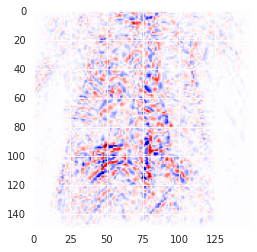

In [78]:
plt.imshow(analysis[0][2])
print("Predicted: {}".format(text[0][0]))
print("Actual: {}".format(text[0][3]))
print("Logit: {}".format(text[0][1]))
print("Probability: {}".format(text[0][2]))

In [ ]:
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]), 'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=EXPLAIN_PATH)

# Contrastive LRP

In [ ]:
def load_image(path):
    img_path = path
    img = preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    x = preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x


def rescale(img):
    return (img - img.min()) / (img.max() - img.min())


def clrp(R, R_dual):
    return np.clip(R - R_dual, a_min=0, a_max=None)


def plot_images(imgs, suptitle=None, titles=None, show=True, save_path="."):
    n = len(imgs)
    if titles is None or len(titles) != n:
        titles = [""] * n
    
    fig, axes = plt.subplots(1, n)
    fig.set_figwidth(5 * n)
#     fig.set_figheight(10)
    
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
    
    for ax, img, t in zip(axes, imgs, titles):
        ax.set_title(t)
        
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    fig.savefig(save_path)
        

def plot_CLRP(R, R_dual, title=None, save_path="."):
    imgs = [rescale(R[0]), rescale(R_dual[0]), rescale(clrp(R, R_dual)[0])]
    titles = ["R", "R_dual", "CLRP"]
    plot_images(imgs, title, titles, save_path=save_path)
    
    
def conservation(H, Y, error=0.5):
    R = H.sum()
    c = np.abs((R - Y)/(Y+1e-9)).max()
    print(c)
    return 0. <= c <= error

In [ ]:
def get_weights(output_size, idx, method="CLRP1"):
    W = np.zeros((output_size, 3))

    if method == "CLRP1":
      # concept weights
      W[idx, 0] = 1
      # not concept weights
      W[:, 1] = 1
    elif method == "CLRP2":
       # concept weights
       W[idx, 0] = 1
       # not concept weights
       W[idx, 1] = -1
    else:
        raise Exception("Unknown method")
    
    return W


def analyze_concept(cmodel, idx, img_pp, rule="lrp.sequential_preset_a", params={}):
    _, s = cmodel.layers[-2].output_shape
    
    W = get_weights(s, idx)
    cmodel.get_layer("concept").set_weights([W])
    
    canalyzer = innvestigate.create_analyzer(rule, cmodel, **params, neuron_selection_mode="index")
    
    R = canalyzer.analyze(img_pp, 0)
    R_dual = canalyzer.analyze(img_pp, 1)
    
    return R, R_dual

In [ ]:
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)

o = keras.layers.Dense(3, use_bias=False, activation='linear', name='concept', trainable=False)(model_wo_sm.output)

cmodel = keras.models.Model(inputs=model.input, outputs=o, name='concept_model')
cmodel.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
label_dict = {j:i for i, j in enumerate(labels)}

for label in labels:
    for img in tqdm(os.listdir(os.path.join("./data/test", label))):
        _, img_pp = load_image(os.path.join("./data/test", label, img))

        R, R_dual = analyze_concept(cmodel, label_dict[label], img_pp)
        plot_CLRP(R, 
                  R_dual, 
                  title="Type: {}".format(label), 
                  save_path=os.path.join("./outputs", "test_clrp_"+label.lower(), img[:-5]+"_clrp.png"))

In [ ]:
label_dict = {j:i for i, j in enumerate(labels)}

R, R_dual = analyze_concept(cmodel, label_dict["NORMAL"], img_pp)
plot_CLRP(R, R_dual, title="Test")

# LIME

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
explanation = explainer.explain_instance(data[0][0].astype('double'), 
                                         model.predict, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=5, 
                                            hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
explainer = lime_image.LimeImageExplainer()
n = 3
#test_images = list(zip(data[0][:n], data[1][:n]))
label_dict = {i:j for i, j in enumerate(labels)}

for i, (x, y) in tqdm(enumerate(list(zip(x_test, y_test))), total=len(x_test)):
    explanation = explainer.explain_instance(x.astype('double'), 
                                         model.predict, 
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=1000);
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=5, 
                                            hide_rest=False)
    x = x[None, :, :, :]

    fig, ax = plt.subplots(1, 1)
    plt.title("Pred: {}, Actual: {}".format(label_dict[np.argmax(model.predict_on_batch(x)[0])], label_dict[y]))
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.savefig(os.path.join("./outputs", "test_lime_"+label_dict[y].lower(), "{}.png".format(i)))

In [ ]:
explainer = lime_image.LimeImageExplainer()
n = 3
#test_images = list(zip(data[0][:n], data[1][:n]))
label_dict = {i:j for i, j in enumerate(labels)}

for label in labels:
    class_num = labels.index(label) if label != "BACTERIA_SUB" else 0
    for img in tqdm(os.listdir(os.path.join("./data/test", label))):
        img_arr = cv2.imread(os.path.join("./data/test", label, img))
        resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)) # Reshaping images to preferred size
        #test_images.append([resized_arr, class_num])
        
        explanation = explainer.explain_instance(resized_arr.astype('double'), 
                                                 model.predict, 
                                                 top_labels=5, 
                                                 hide_color=0, 
                                                 num_samples=1000)
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                    positive_only=True, 
                                                    num_features=5, 
                                                    hide_rest=False)
        x = x[None, :, :, :]
        
        plt.title("Pred: {}, Actual: {}".format(label_dict[np.argmax(model.predict_on_batch(x)[0])], label_dict[y]))
        plt.imsave(os.path.join("./outputs", "test_lime_"+label.lower(), img[:-5]+"_lime.png"), 
                   mark_boundaries(temp / 2 + 0.5, mask))